In [1]:
# Setup: libs, style, kagglehub download, distinct paths
import os, glob, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

# 0) Download with kagglehub (ensure 'kagglehub' is installed: pip install kagglehub)
import kagglehub

path = kagglehub.dataset_download("harishkumardatalab/housing-price-prediction")
print("Path to dataset files:", path)


100%|██████████| 4.63k/4.63k [00:00<00:00, 3.61MB/s]

Extracting model files...
Path to dataset files: C:\Users\OMEN\.cache\kagglehub\datasets\harishkumardatalab\housing-price-prediction\versions\1


In [2]:
INPUT_CSV = r"C:\Users\OMEN\.cache\kagglehub\datasets\harishkumardatalab\housing-price-prediction\versions\1\Housing.csv"
OUTPUT_CSV = r"C:\Users\OMEN\.cache\kagglehub\datasets\harishkumardatalab\housing-price-prediction\versions\1\Housing_Cleaned.csv"

Shape: (545, 13)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished



Dtypes:
 price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

Null counts:
 price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

Duplicate rows: 0


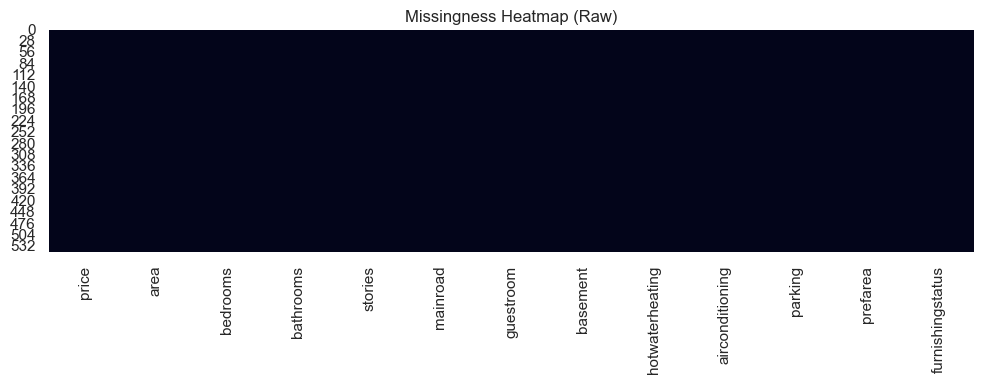

In [3]:
# 1) Import and explore: structure, types, nulls
df = pd.read_csv(INPUT_CSV)
print("Shape:", df.shape)
display(df.head(10))
print("\nDtypes:\n", df.dtypes)
print("\nNull counts:\n", df.isna().sum().sort_values(ascending=False))
print("\nDuplicate rows:", df.duplicated().sum())

# Visual: missingness heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missingness Heatmap (Raw)")
plt.tight_layout()
plt.show()


In [4]:
# 2) Preprocess with ColumnTransformer: impute -> encode -> scale
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

data = df.copy()

# Identify target; adjust if the dataset uses a different name for price
# Try common names in such datasets
possible_targets = ["Price", "SalePrice", "price", "Sale_Price"]
target = next((c for c in possible_targets if c in data.columns), None)
assert target is not None, f"Could not find a target column among: {possible_targets}"
y = data[target].astype(float)

# Drop obvious IDs if present
drop_like = [c for c in data.columns if c.lower() in {"id"}]
X = data.drop(columns=[target] + drop_like, errors="ignore")

# Column types
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)


In [5]:
# 3) Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape)


(436, 12) (109, 12)


In [6]:
# 4) Fit Linear Regression in a Pipeline
from sklearn.linear_model import LinearRegression

reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

reg.fit(X_train, y_train)

# Extract feature names for interpretation
ohe = reg.named_steps["preprocess"].named_transformers_["cat"].named_steps["ohe"] if cat_cols else None
ohe_names = ohe.get_feature_names_out(cat_cols).tolist() if ohe is not None else []
feature_names = num_cols + ohe_names
print("Total features used:", len(feature_names))


Total features used: 20


In [7]:
# 5) Evaluate with MAE, MSE, R² (+ RMSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

preds = reg.predict(X_test)
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, preds)

print(f"MAE  : {mae:,.4f}")
print(f"MSE  : {mse:,.4f}")
print(f"RMSE : {rmse:,.4f}")
print(f"R²   : {r2:,.4f}")


MAE  : 970,043.4039
MSE  : 1,754,318,687,330.6689
RMSE : 1,324,506.9601
R²   : 0.6529


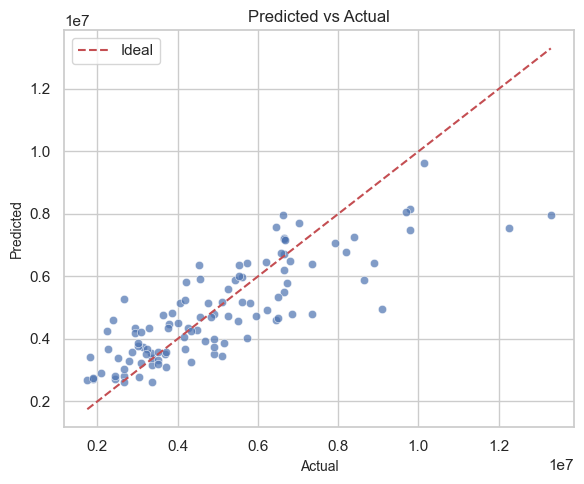

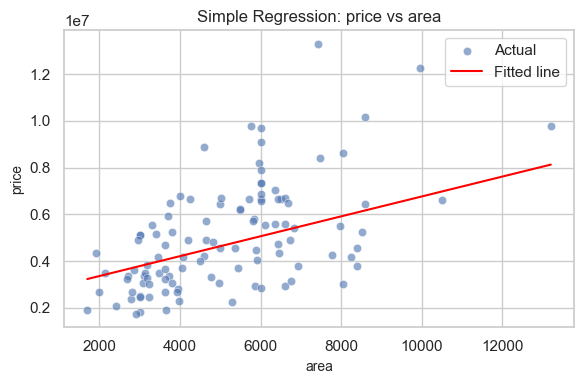

In [8]:
# 6) Plots: Predicted vs Actual, and simple-regression line for top numeric feature

# A) Predicted vs Actual with identity line
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=preds, alpha=0.7)
lims = [min(y_test.min(), preds.min()), max(y_test.max(), preds.max())]
plt.plot(lims, lims, "r--", label="Ideal")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

# B) Simple regression line for top numeric predictor by |corr|
top_num = None
if num_cols:
    # Compute correlations on train for numeric columns only (drop missing)
    corr_vals = {}
    tmp_train = pd.concat([X_train[num_cols], y_train], axis=1).dropna()
    for c in num_cols:
        if tmp_train[c].nunique() > 1:
            corr_vals[c] = tmp_train[[c, y_train.name]].corr().iloc[0, 1]
    if corr_vals:
        top_num = max(corr_vals, key=lambda k: abs(corr_vals[k]))

if top_num is not None:
    from sklearn.linear_model import LinearRegression
    # Fit simple regression on top_num
    sX_tr = X_train[[top_num]].values
    sX_te = X_test[[top_num]].values
    s_lr = LinearRegression().fit(sX_tr, y_train)
    y_line = s_lr.predict(sX_te)

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X_test[top_num], y=y_test, alpha=0.6, label="Actual")
    # Plot fitted line over sorted X
    order = np.argsort(sX_te[:, 0])
    plt.plot(X_test[top_num].values[order], y_line[order], color="red", label="Fitted line")
    plt.xlabel(top_num)
    plt.ylabel(target)
    plt.title(f"Simple Regression: {target} vs {top_num}")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [9]:
# 7) Coefficient interpretation (standardized scale due to StandardScaler)
coef = reg.named_steps["model"].coef_
intercept = reg.named_steps["model"].intercept_
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef}).sort_values("coef", key=lambda s: s.abs(), ascending=False)
display(coef_df.head(15))
print("Intercept:", intercept)


,feature,coef
2,bathrooms,521879.027748
0,area,519552.416340
14,airconditioning_yes,395713.367922
13,airconditioning_no,-395713.367922
3,stories,349251.438906
12,hotwaterheating_yes,342324.942669
11,hotwaterheating_no,-342324.942669
15,prefarea_no,-314945.282657
16,prefarea_yes,314945.282657
19,furnishingstatus_unfurnished,-233469.435624


Intercept: 5337102.103750264


In [10]:
# 8) Save cleaned, fully numeric model matrix to OUTPUT_CSV
# Fit preprocess on full data for export consistency
Xt = reg.named_steps["preprocess"].fit_transform(X)
# Convert to dense if sparse
if hasattr(Xt, "toarray"):
    Xt = Xt.toarray()
Xt_df = pd.DataFrame(Xt, columns=feature_names, index=X.index)
Xt_df[target] = y.values

Xt_df.to_csv(OUTPUT_CSV, index=False)
print("Saved cleaned model matrix to:", OUTPUT_CSV)


Saved cleaned model matrix to: C:\Users\OMEN\.cache\kagglehub\datasets\harishkumardatalab\housing-price-prediction\versions\1\Housing_Cleaned.csv
